In [1]:
# Importing Libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [2]:
def simulate_ball_throwing(init_x, init_y, init_speed, launch_angle, dt, max_time, g=9.81):
    positions = []
    t = 0.0
    vx = init_speed * math.cos(math.radians(launch_angle))
    vy = init_speed * math.sin(math.radians(launch_angle))
    x, y = init_x, init_y

    while t <= max_time and y >= 0:
        positions.append(np.array([x, y]))
        x += vx * dt
        y += vy * dt - 0.5 * g * dt * dt
        vy -= g * dt
        t += dt

    return positions

In [3]:
def simulate_noisy_observations(trajectory, obs_noise_std=1.0, dropout_prob=0.3, dropout_interval=None):
    observations = []
    t = 0
    dropout_start = None
    dropout_end = None
    if dropout_interval:
        dropout_start = np.random.randint(0, len(trajectory) - dropout_interval)
        dropout_end = dropout_start + dropout_interval

    while t < len(trajectory):
        if dropout_interval and dropout_start <= t < dropout_end:
            observations.append(None)
        elif np.random.rand() < dropout_prob:
            observations.append(None)
        else:
            true_pos = trajectory[t]
            noisy_pos = true_pos + np.random.normal(0, obs_noise_std, size=2)
            observations.append(noisy_pos)
        t += 1
    return observations

In [4]:
class ParticleFilter:
    def __init__(self, num_particles, dt, process_noise_std, observation_noise_std,
                 x_range=(0, 50), y_range=(0, 50),
                 speed_range=(18, 22), angle_range=(40, 50), g=9.81):
        self.N = num_particles
        self.dt = dt
        self.proc_std = process_noise_std
        self.obs_std = observation_noise_std
        self.g = g

        x0 = np.random.uniform(*x_range, size=self.N)
        y0 = np.random.uniform(*y_range, size=self.N)
        speeds = np.random.uniform(*speed_range, size=self.N)
        angles = np.random.uniform(np.radians(angle_range[0]),
                                   np.radians(angle_range[1]), size=self.N)
        vx0 = speeds * np.cos(angles)
        vy0 = speeds * np.sin(angles)

        self.particles = np.stack([x0, y0, vx0, vy0], axis=1)
        self.weights = np.ones(self.N) / self.N

    def predict(self, dt_multiplier=1):
        for particle in self.particles:
            x, y, vx, vy = particle
            dt = self.dt * dt_multiplier
            x += vx * dt
            y += vy * dt - 0.5 * self.g * dt**2
            vy -= self.g * dt

            if y < 0:
                y = 0
                vx = 0
                vy = 0

            particle[:] = [x, y, vx, vy]

    def update(self, obs):
        if obs is None:
            return
        d2 = np.sum((self.particles[:, :2] - obs) ** 2, axis=1)
        lik = np.exp(-0.5 * d2 / (self.obs_std ** 2))
        if lik.sum() == 0:
            lik = np.ones_like(lik)
        self.weights = lik / lik.sum()

    def resample(self):
        positions = (np.arange(self.N) + np.random.rand()) / self.N
        cum = np.cumsum(self.weights)
        idx = np.searchsorted(cum, positions)
        self.particles = self.particles[idx]
        self.weights.fill(1.0 / self.N)

    def estimate(self):
        return np.average(self.particles, axis=0, weights=self.weights)

In [5]:
def visualize_with_dropout_highlight(pfilters, true_trajs, observations, DT):
    num_balls = len(pfilters)
    est_trajs = [[] for _ in range(num_balls)]
    max_len = max(len(traj) for traj in true_trajs)

    for i in range(num_balls):
        pf = pfilters[i]
        obs_list = observations[i]

        for t in range(max_len):
            pf.predict()
            if t < len(obs_list):
                obs = obs_list[t]
                if obs is not None:
                    pf.update(obs)
                    pf.resample()
            est = pf.estimate()
            est_trajs[i].append(est)

    plt.figure(figsize=(10, 7))
    base_colors = ['deepskyblue', 'magenta', 'green', 'orange', 'purple', 'red', 'brown', 'teal']

    for i in range(num_balls):
        color = base_colors[i % len(base_colors)]
        stroke = pe.withStroke(linewidth=5, foreground='black')

        true_xy = np.array(true_trajs[i])
        if len(true_xy) > 0:
            plt.plot(true_xy[:, 0], true_xy[:, 1], linestyle='--', color=color,
                     linewidth=3, label=f'True Ball {i+1}', path_effects=[stroke])

        est_xy = np.array(est_trajs[i])
        if len(est_xy) > 0:
            plt.plot(est_xy[:, 0], est_xy[:, 1], linestyle='-', color='black',
                     linewidth=1.5, label=f'Est Ball {i+1}')

    
        obs_xy_present = []
        dropout_indices = []

        for idx, obs in enumerate(observations[i]):
            if obs is None:
                dropout_indices.append(idx)
            else:
                obs_xy_present.append(obs)

        obs_xy_present = np.array(obs_xy_present)
        if len(obs_xy_present) > 0:
            plt.scatter(obs_xy_present[:, 0], obs_xy_present[:, 1], s=10, alpha=0.6,
                        label=f'Obs Ball {i+1}', color=color)

        # Dropout varsa tahmin edilen konumları kırmızı çarpı ile göster
        if len(dropout_indices) > 0:
            dropout_points = np.array([est_trajs[i][j] for j in dropout_indices])
            plt.scatter(dropout_points[:, 0], dropout_points[:, 1], s=60, color='red',
                        marker='x', label=f'Dropout Ball {i+1}')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Particle Filter with Dropout Highlight')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Ball 1: 49 dropout frames
Ball 2: 65 dropout frames
Ball 3: 99 dropout frames


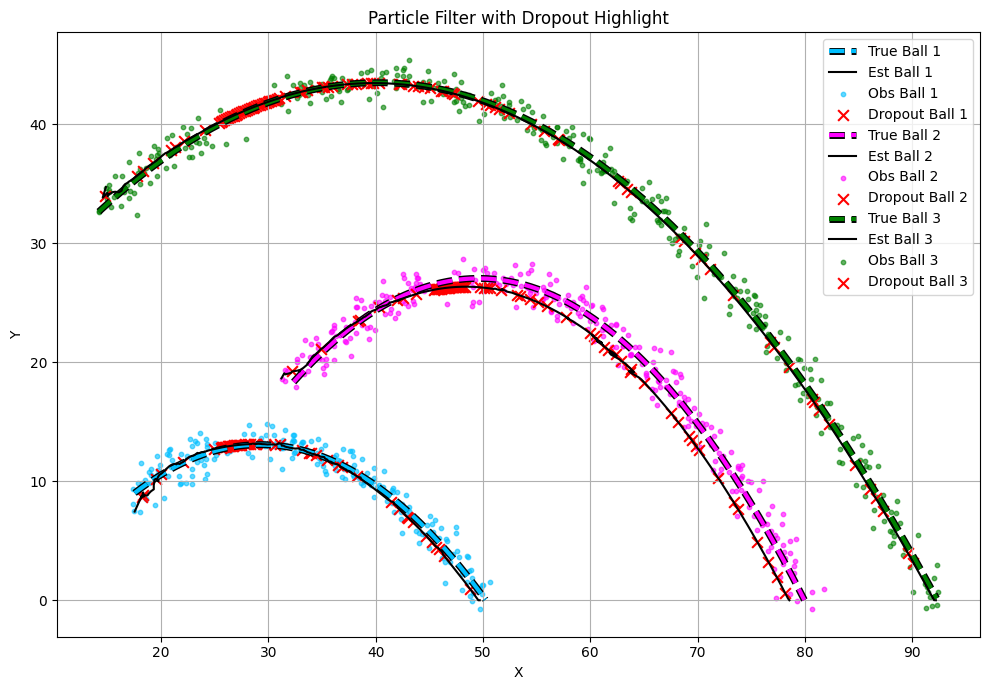

In [6]:
if __name__ == "__main__":
    N_BALLS = 3
    DT = 0.01
    MAX_TIME = 10
    NOISE_STD = 0.9
    num_particles = 20000

    init_xs = np.random.uniform(0, 50, size=N_BALLS)
    init_ys = np.random.uniform(0, 50, size=N_BALLS)
    speeds = np.random.uniform(15, 25, size=N_BALLS)
    angles = np.random.uniform(30, 50, size=N_BALLS)
    dropout_intervals = np.random.randint(15, 40, size=N_BALLS)

    true_trajs = []
    observations = []
    pfilters = []

    for i in range(N_BALLS):
        traj = simulate_ball_throwing(init_xs[i], init_ys[i], speeds[i], angles[i], DT, MAX_TIME)
        obs = simulate_noisy_observations(traj, obs_noise_std=NOISE_STD,
                                          dropout_prob=0.15, dropout_interval=dropout_intervals[i])
        obs = [o if o is not None and not np.isnan(o).any() else None for o in obs]

        true_trajs.append(traj)
        observations.append(obs)

        pf = ParticleFilter(
            num_particles, DT, process_noise_std=0.05,
            observation_noise_std=NOISE_STD,
            x_range=(0, 50),
            y_range=(0, 50),
            speed_range=(speeds[i]-1, speeds[i]+1),
            angle_range=(angles[i]-2, angles[i]+2)
        )
        pfilters.append(pf)
    for i in range(N_BALLS):
            dropout_count = sum([1 for o in observations[i] if o is None])
            print(f"Ball {i+1}: {dropout_count} dropout frames")


   
    visualize_with_dropout_highlight(pfilters, true_trajs, observations, DT)